Fixed grid with obstacles (1 = obstacle, 0 = free space):
[[0 0 0 0 1 0 0 0 0 0]
 [0 1 1 0 1 0 1 1 1 0]
 [0 0 0 0 1 0 0 0 1 0]
 [0 1 0 0 1 0 0 1 1 0]
 [0 1 0 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 0]
 [0 1 1 1 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 1 0 1 1 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


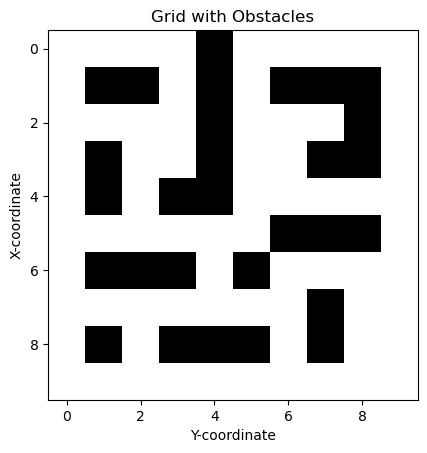

Enter the starting point x-coordinate (0 to 9):  0
Enter the starting point y-coordinate (0 to 9):  0
Enter the destination x-coordinate (0 to 9):  9
Enter the destination y-coordinate (0 to 9):  9


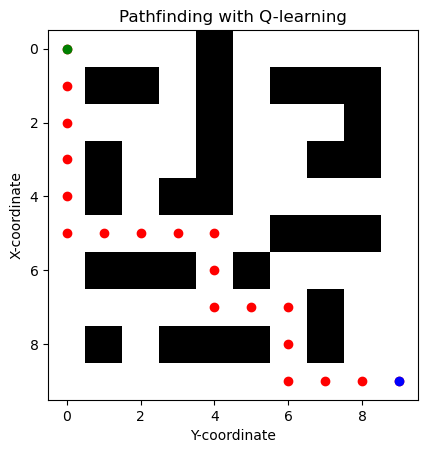

In [20]:
import numpy as np
import heapq
import matplotlib.pyplot as plt
import random

# Define the grid dimensions and obstacles
GRID_SIZE = 10
ALPHA = 0.1  # Learning rate for Q-learning
GAMMA = 0.9  # Discount factor for Q-learning
EPSILON = 0.1  # Exploration rate for Q-learning
EPISODES = 1000  # Number of training episodes

# Create a predefined grid with obstacles (1 = obstacle, 0 = free space)
def create_fixed_grid():
    grid = np.array([
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 0, 1, 1, 1, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
        [0, 1, 0, 0, 1, 0, 0, 1, 1, 0],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 0],
        [0, 1, 1, 1, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 1, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    ])
    return grid

# Heuristic function (Manhattan distance)
def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

# A* pathfinding algorithm (not used in Q-learning version, but kept for reference)
def a_star(grid, start, end):
    rows, cols = grid.shape
    open_list = []
    heapq.heappush(open_list, (0, start))
    came_from = {}
    g_score = {start: 0}
    f_score = {start: heuristic(start, end)}
    
    while open_list:
        _, current = heapq.heappop(open_list)
        
        if current == end:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            return path[::-1]  # Return reversed path
        
        for direction in [(0, 1), (1, 0), (0, -1), (-1, 0)]:  # Right, Down, Left, Up
            neighbor = (current[0] + direction[0], current[1] + direction[1])
            
            if 0 <= neighbor[0] < rows and 0 <= neighbor[1] < cols:
                if grid[neighbor] == 1:  # Skip obstacles
                    continue
                
                tentative_g_score = g_score[current] + 1
                if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + heuristic(neighbor, end)
                    heapq.heappush(open_list, (f_score[neighbor], neighbor))
    
    return None  # No path found

# Q-learning algorithm for improving pathfinding
def q_learning(grid, start, end):
    q_table = np.zeros((GRID_SIZE, GRID_SIZE, 4))  # Initialize Q-table for 4 actions (right, down, left, up)
    actions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Right, Down, Left, Up

    for episode in range(EPISODES):
        current = start
        while current != end:
            if random.uniform(0, 1) < EPSILON:
                action_idx = np.random.randint(0, 4)  # Exploration: random action
            else:
                action_idx = np.argmax(q_table[current[0], current[1]])  # Exploitation: choose best action

            next_move = (current[0] + actions[action_idx][0], current[1] + actions[action_idx][1])

            # If next_move is out of bounds or an obstacle, give a large negative reward
            if not (0 <= next_move[0] < GRID_SIZE and 0 <= next_move[1] < GRID_SIZE) or grid[next_move] == 1:
                reward = -100
                next_move = current  # Stay in place if hitting obstacle
            elif next_move == end:
                reward = 100  # Reward for reaching the goal
            else:
                reward = -1  # Slight penalty for each step taken

            # Update Q-table
            old_value = q_table[current[0], current[1], action_idx]
            future_value = np.max(q_table[next_move[0], next_move[1]])
            q_table[current[0], current[1], action_idx] = old_value + ALPHA * (reward + GAMMA * future_value - old_value)

            current = next_move  # Move to the next state

    return q_table  # Return the learned Q-table

# Choose the best path from the learned Q-table
def q_learning_path(grid, start, end, q_table):
    current = start
    path = [current]
    actions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Right, Down, Left, Up

    while current != end:
        action_idx = np.argmax(q_table[current[0], current[1]])
        current = (current[0] + actions[action_idx][0], current[1] + actions[action_idx][1])

        if not (0 <= current[0] < GRID_SIZE and 0 <= current[1] < GRID_SIZE) or grid[current] == 1:
            break  # If hitting an obstacle, stop (shouldn't happen with proper training)
        path.append(current)

    return path

# Main function to set up the grid, display it, get user-defined points, and visualize the result
def main():
    grid = create_fixed_grid()
    
    # Display the grid with obstacles
    print("Fixed grid with obstacles (1 = obstacle, 0 = free space):")
    print(grid)
    
    # Visualization of the grid with obstacles
    plt.imshow(grid, cmap='binary')
    plt.title("Grid with Obstacles")
    plt.xlabel("Y-coordinate")
    plt.ylabel("X-coordinate")
    plt.show()

    # Get user-defined start and end points
    start_x = int(input(f"Enter the starting point x-coordinate (0 to {GRID_SIZE-1}): "))
    start_y = int(input(f"Enter the starting point y-coordinate (0 to {GRID_SIZE-1}): "))
    end_x = int(input(f"Enter the destination x-coordinate (0 to {GRID_SIZE-1}): "))
    end_y = int(input(f"Enter the destination y-coordinate (0 to {GRID_SIZE-1}): "))
    
    start = (start_x, start_y)
    end = (end_x, end_y)
    
    # Check if start or end points are on obstacles
    if grid[start] == 1 or grid[end] == 1:
        print("Error: Start or end point is on an obstacle. Please choose different points.")
        return
    
    # Train the Q-learning algorithm
    q_table = q_learning(grid, start, end)
    
    # Find the path using Q-learning
    path = q_learning_path(grid, start, end, q_table)
    
    # Visualization of the path
    plt.imshow(grid, cmap='binary')
    if path:
        for (x, y) in path:
            plt.plot(y, x, "ro")  # 'ro' means red dots for the path
    plt.plot(start[1], start[0], "go")  # Start point in green
    plt.plot(end[1], end[0], "bo")  # End point in blue
    plt.title("Pathfinding with Q-learning")
    
    # Label the axes
    plt.xlabel("Y-coordinate")
    plt.ylabel("X-coordinate")
    
    plt.show()

main()
